## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Подготовка и анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.head())
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Данные в таблице с 2018-03-01 00:00:00 по 2018-08-31 23:50:00.


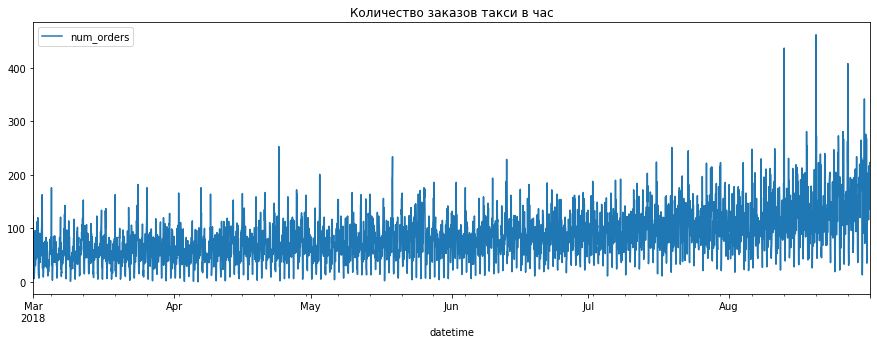

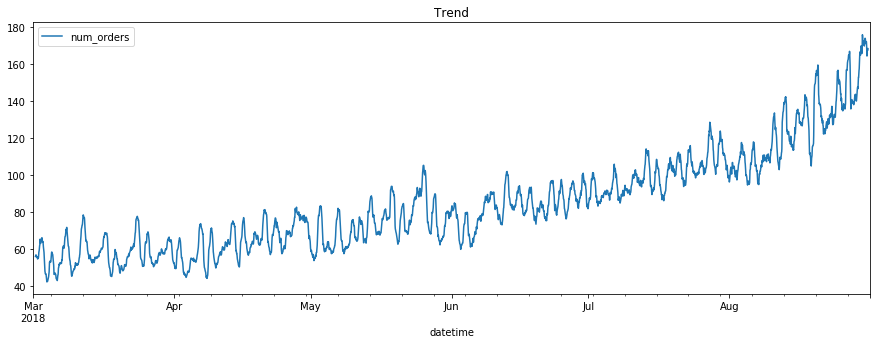

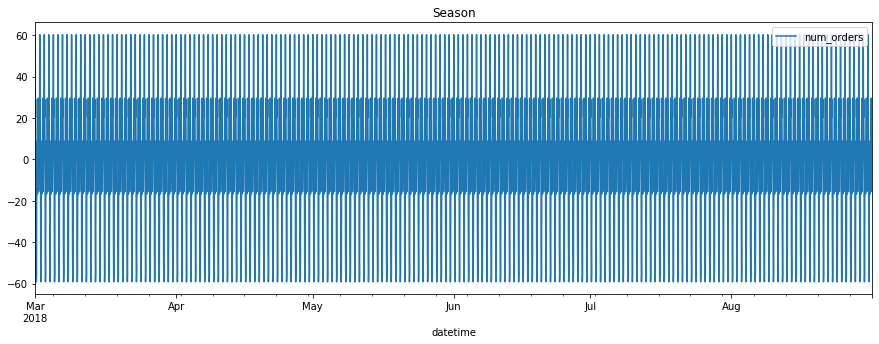

In [4]:
data.sort_index(inplace=True)
print(f"Данные в таблице с {data.index.min()} по {data.index.max()}.")
data = data.resample('1H').sum()
data.plot(figsize = (15,5))
plt.title('Количество заказов такси в час')
plt.show()

decomposed = seasonal_decompose(data)
decomposed.trend.plot(figsize = (15,5))
plt.title('Trend')
plt.show()

decomposed.seasonal.plot(figsize = (15,5))
plt.title('Season')
plt.show()

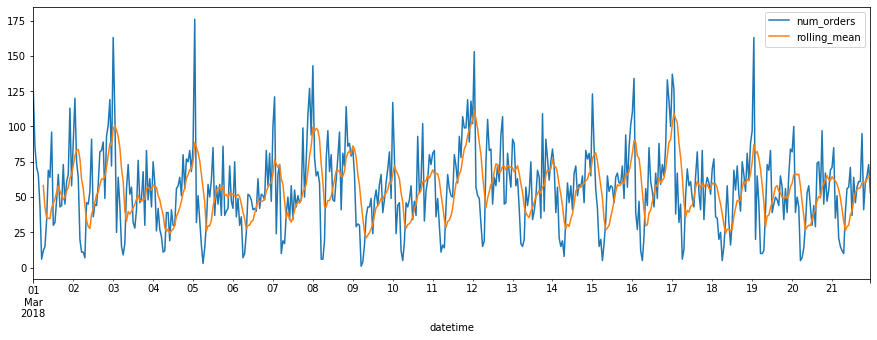

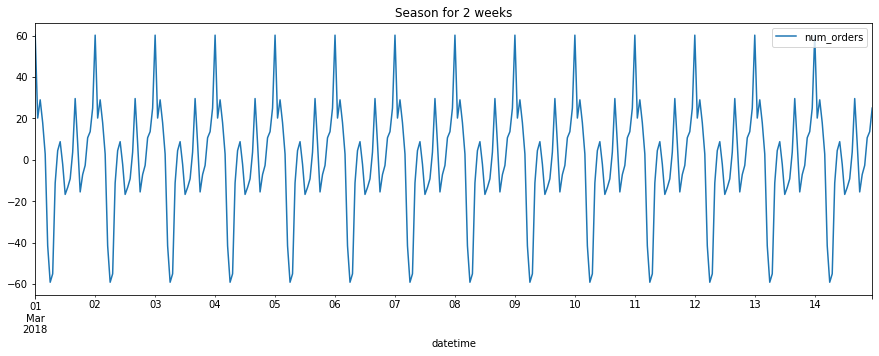

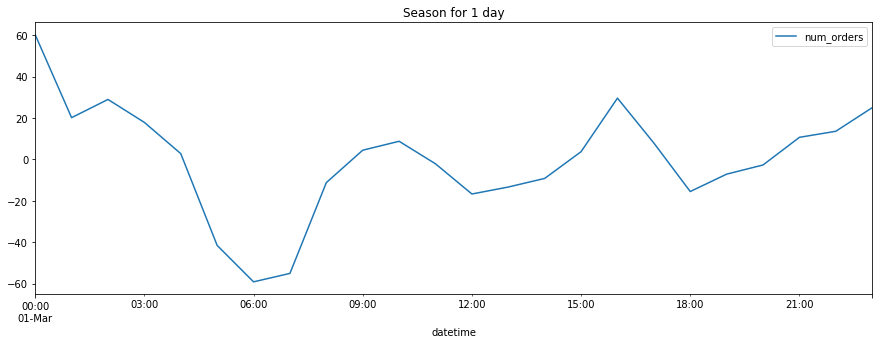

,num_orders,rolling_mean,dayofweek
datetime,,,
2018-03-01 00:00:00,124,NaN,3
2018-03-01 01:00:00,85,NaN,3
2018-03-01 02:00:00,71,NaN,3
2018-03-01 03:00:00,66,NaN,3
2018-03-01 04:00:00,43,NaN,3


In [5]:
# посмотрим данные на меньшем промежутке времени

data_march = deepcopy(data['2018-03-01':'2018-03-21'])
data_march['rolling_mean'] = data_march.rolling(7).mean()
data_march.plot(figsize = (15,5))
plt.show()

decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-14'].plot(figsize = (15,5))
plt.title('Season for 2 weeks')
plt.show()
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(figsize = (15,5))
plt.title('Season for 1 day')
plt.show()

data_march['dayofweek'] = data_march.index.dayofweek
display(data_march.head())

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = deepcopy(data)
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

data_new = make_features(data, 24, 7)
data_new = data_new.dropna()
display(data_new.head())

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,65.714286
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.285714
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,79.000000
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,83.285714
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,83.714286


In [7]:
train, valid = train_test_split(data_new, shuffle = False, test_size = 0.4)
valid, test = train_test_split(valid, shuffle = False, test_size = 0.5)

In [8]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis = 1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

### Вывод:
Я загрузила таблицу с историческими данными о заказах такси в аэропортах (26496 строк и 2 колонки). Таблица содержит данные с 2018-03-01 00:00:00 по 2018-08-31 23:50:00. Я выполнила ресемплирование данных по одному часу (изначально таблица содержала данные о каждых 10 минутах). Проанализировав данные и нрафики можно утверждать, что количество заказов такси постоянно увеличевается; также можно утверждать о сезонности с периодом день. Я дополнила данные следующими признаками месяц, день, день недели, а также скользящее среднее и отстающие значения.
Данные я разбила на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Целевой признак - количество заказов.

## Обучение

In [9]:
# DummyClassifier проверка модели на адекватность

print("Результаты модели DummyRegressor (проверка модели на адекватность)")
model = DummyRegressor(strategy='median')
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели DummyRegressor (проверка модели на адекватность)
RMSE: 45.16388784610836


In [10]:
# LinearRegression

print("Результаты модели LinearRegression")
model = LinearRegression()
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели LinearRegression
RMSE: 28.50999399868335


In [11]:
#RandomForestRegressor

print("Результаты модели RandomForestRegressor")
model = RandomForestRegressor(n_estimators=41, max_depth = 16, random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели RandomForestRegressor
RMSE: 28.378519872882286


#код для подбора параметров RandomForestRegressor

n_estimatots = 0
max_depth = 0
best_score = 100
for depth in range(1,50,5):
    for n_est in range(1,50,5):
        model = RandomForestRegressor(random_state = 123, max_depth=depth, n_estimators = n_est)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted)
        RMSE = mse** 0.5
        if best_score>RMSE:
            best_score=RMSE
            max_depth = depth
            n_estimators = n_est

model = RandomForestRegressor(n_estimators=n_estimators, max_depth = max_depth, random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("Результаты модели model_RandomForestRegressor")
print("RMSE:", mse ** 0.5)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", n_estimators)

In [12]:
# CatBoostClassifier

print("Результаты модели CatBoostRegressor")
model = CatBoostRegressor(iterations = 6, depth = 7, learning_rate = 0.7, random_state=123)
model.fit(features_train, target_train, verbose=False)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели CatBoostRegressor
RMSE: 29.486461370878814


#код для подбора параметров CatBoostClassifier

itera = 0
max_depth = 0
best_score = 100
for repeat in range(1,50,5):
    for dep in range(1,16,3):
        model = CatBoostRegressor(iterations = repeat, depth = dep, learning_rate = 0.7, random_state=123)
        model.fit(features_train, target_train, verbose = False)
        predicted = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted)
        RMSE = mse** 0.5
        if best_score>RMSE:
            best_score=RMSE
            max_depth = dep
            itera = repeat

model = CatBoostRegressor(iterations=itera, depth = max_depth, learning_rate = 0.7, random_state = 123)
model.fit(features_train, target_train, verbose = False)
predicted = model.predict(features_valid)
mse = mean_squared_error(target_valid, predicted)
print("Результаты модели CatBoostClassifier")
print("RMSE:", mse ** 0.5)
print("Лучшая глубина:", max_depth, "   |   Лучшее кол-во деревьев:", itera)
%time

### Вывод:
Я обучила модели и проверила результаты обученных моделей на валидационной выборке. Для оценка качества моделей я использовала метрику RMSE. Модели показали сл. результаты в предсказании количества заказов такси:

DummyClassifier: 45

LinearRegression: 28.5

RandomForestRegressor (n_estimators=41, max_depth = 16): 28.4

CatBoostClassifier (iterations = 6, depth = 7, learning_rate = 0.7): 29.5


Самой точной оказалась модель: RandomForestRegressor, однако LinearRegression показала практически такой же результат. Проверим модели на тестовых данных.

## Тестирование

In [13]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train,target_valid])

In [14]:
# LinearRegression

print("Результаты модели LinearRegression")
model = LinearRegression()
model.fit(features_train, target_train)
predicted = model.predict(features_test)
mse = mean_squared_error(target_test, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели LinearRegression
RMSE: 40.616422146924585


In [15]:
#RandomForestRegressor

print("Результаты модели RandomForestRegressor")
model = RandomForestRegressor(n_estimators=41, max_depth = 16, random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
mse = mean_squared_error(target_test, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели RandomForestRegressor
RMSE: 42.63775797527103


In [16]:
# CatBoostClassifier

print("Результаты модели CatBoostRegressor")
model = CatBoostRegressor(iterations = 6, depth = 7, learning_rate = 0.7, random_state=123)
model.fit(features_train, target_train, verbose=False)
predicted = model.predict(features_test)
mse = mean_squared_error(target_test, predicted)
print("RMSE:", mse ** 0.5)

Результаты модели CatBoostRegressor
RMSE: 45.491206391666545


### Вывод:
На тестовых данных лучше себя повела модель LinearRegression, её RMSE = 40. А RandomForestRegressor с параметрами n_estimators=41, max_depth = 16 показал результаты хуже: RMSE = 42,6. На тестовых данных стоит проверять 2-3 модели, которые выдали лучшие результаты на валидационных данных, т.к. на тестовых данных модель может отработать хуже.